In [1]:
# import lovelyplots
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scienceplots
from matplotlib import tri
from matplotlib.colors import TwoSlopeNorm
from qutip import (
    average_gate_fidelity,
    destroy,
    qeye,
    tensor,
)
from qutip_qip.operations import ISWAP, SQRTISWAP
from tqdm.notebook import tqdm

In [2]:
# params
N = 50
g3 = 60e6  # (g3 = 60 Mhz / 2pi)
lambdaq = 0.1
n_s_list = np.linspace(1, 5, N)  # sqrt of pump photon number in SNAIL mode
delta_list = 1e6 * np.linspace(50, 200, 6)  # MHz

# full_pulse = geff * t_f => geff = full_pulse / t_f
# pi/2 pulse for iSWAP, pi/4 for sqrtiSWAP
if True:
    full_pulse = np.pi / 2
    intended_gate = ISWAP([0, 1]).get_compact_qobj()
else:
    full_pulse = np.pi / 4
    intended_gate = SQRTISWAP([0, 1]).get_compact_qobj()

# define qutip ladder operators
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()
q4dag = q4.dag()

In [3]:
# Define system operators
a = tensor(destroy(2), qeye(2))  # Mode a
b = tensor(qeye(2), destroy(2))  # Mode b

# Define pump strengths
time_list = np.linspace(0, 500e-9, 100)  # Sweep over time duration (750 ns)
eta_list = np.sqrt(n_s_list)  # Compute eta values

# Store population results
pop_matrix = np.zeros((len(time_list), len(n_s_list)))  # Swap dimensions

# Initial state |01⟩ (second mode excited)
initial_state = np.array([0, 1, 0, 0])

# Compute pi/2 transition line
t_pi2 = np.pi / (12 * np.abs(eta_list) * g3 * lambdaq**2)

# Compute population over time for different pump strengths
for j, t in enumerate(time_list):  # Time index first
    for i, eta in enumerate(eta_list):  # Pump strength second
        H = (
            6 * np.abs(eta) * lambdaq**2 * g3 * (a * b.dag() + a.dag() * b)
        )  # Hamiltonian
        U = (-1j * H * t).expm()  # Time evolution operator
        new_state = U.full() @ initial_state  # Evolve state
        pop_matrix[j, i] = np.abs(new_state[1]) ** 2  # Population of mode a

In [4]:
fidelity_dict = {}  # to store fidelity values for each delta
tf_dict = {}  # to store g_eff values for each delta
eta_dict = {}
for delta in tqdm(delta_list):
    fidelity_list = []
    tf_list = []  # store g_eff for this delta
    eta_list = []
    for n_s in n_s_list:
        eta = np.sqrt(n_s)
        g_eff = 6 * eta * g3 * (lambdaq**2)
        t_f = full_pulse / g_eff

        # H(t) = g_eff * exp(-i * delta * t) * interaction_term
        interaction_term = q1dag * q2 + q1 * q2dag
        spectator_term = q3dag * q4 + q3 * q4dag
        # spectator_term = q3dag + q3

        # Integral of the exponential factor
        # integral_term = (1j *(-1 + np.cos(t_f * delta)))/delta + np.sin(t_f * delta)/delta
        integral_term = 2 * np.sin(t_f * delta / 2) / delta
        # better_integral_term = (
        #     np.sin(t_f * delta) / delta + 1j * (1 - np.cos(t_f * delta)) / delta
        # )
        # integral_term = better_integral_term

        # Time evolution operator U(t_f)
        # NOTE sqrt(2) to scale to scale spectator to be on both left and right of intended
        multiple_scale_factor = 1  # / np.log(2)
        U_t_f = (
            1j
            * g_eff
            * (
                t_f * interaction_term
                + multiple_scale_factor * integral_term * (spectator_term)
            )
        ).expm()

        # Fidelity calculation
        # Define the target iSWAP gate
        # target_iswap = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
        target_iswap = tensor(intended_gate, qeye([2, 2]))
        fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
        fidelity_list.append(fidelity)
        tf_list.append(t_f)
        eta_list.append(eta)

    # Store fidelity list and g_eff list for current delta
    fidelity_dict[delta] = fidelity_list
    tf_dict[delta] = tf_list
    eta_dict[delta] = eta_list

  0%|          | 0/6 [00:00<?, ?it/s]

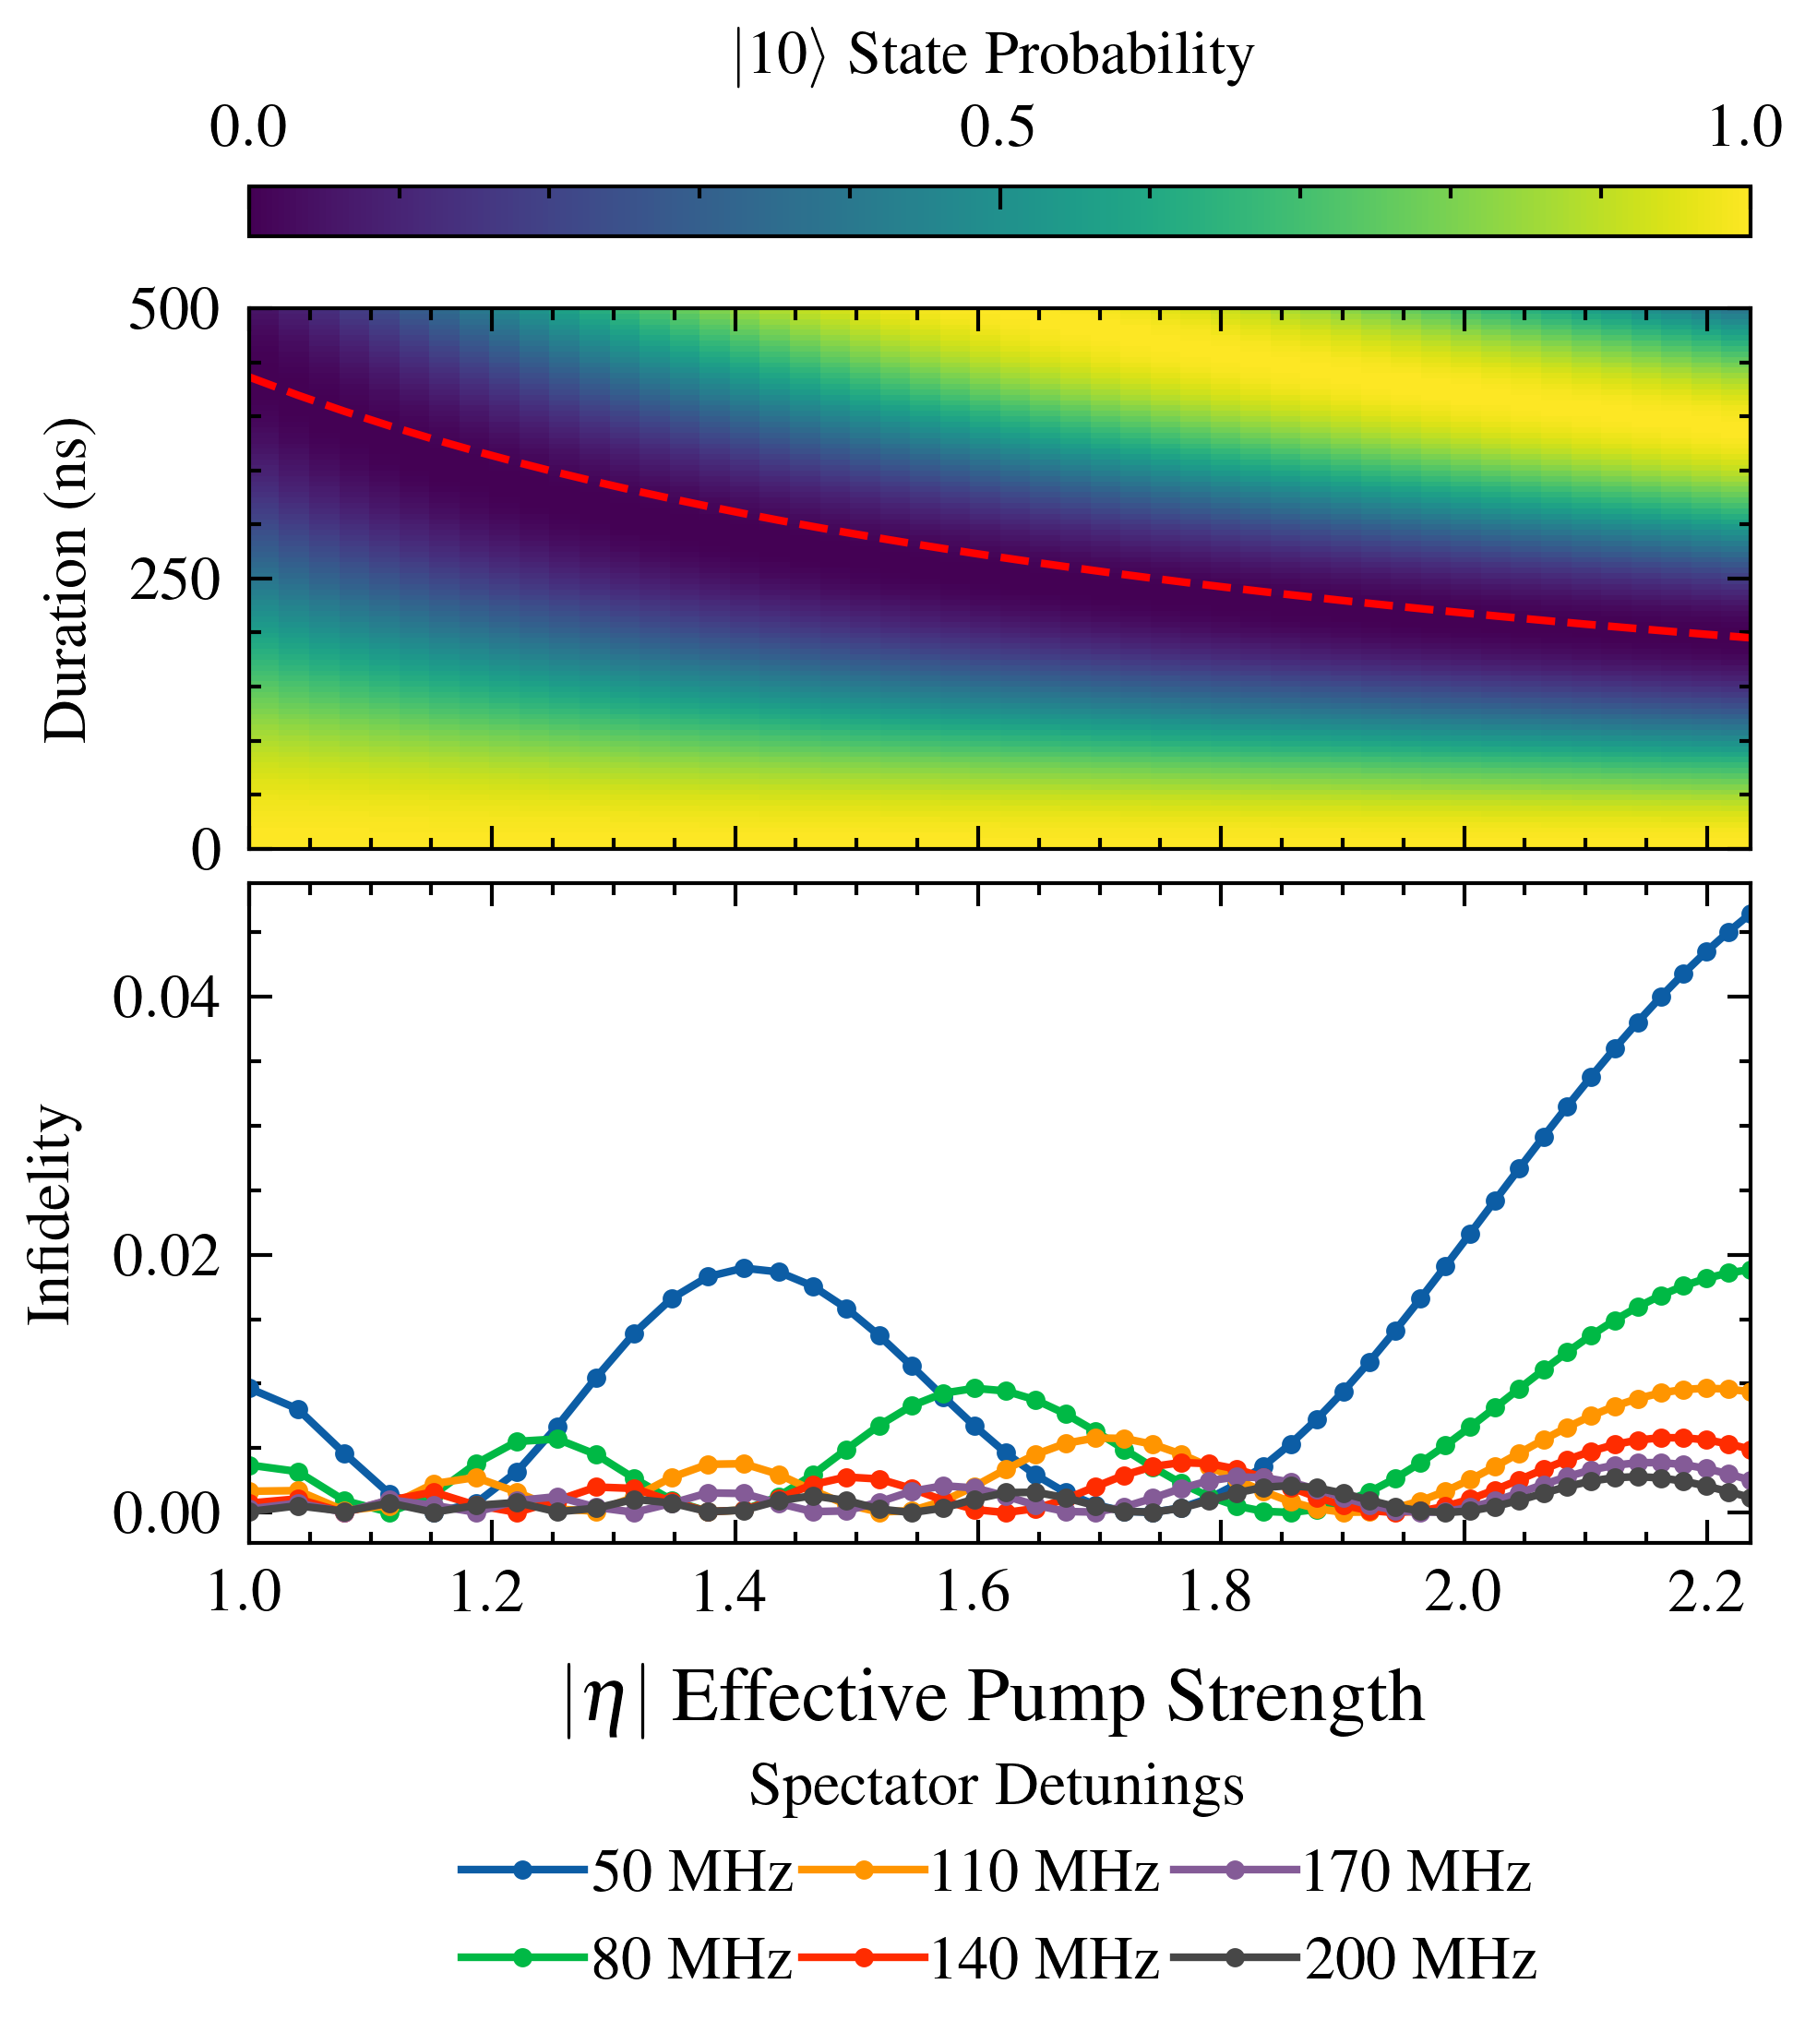

In [5]:
legend_offset = 0.15
subplot_spacing = 0.05  # Reduce space between subplots
legend_y_offset = -legend_offset - 0.1  # Increase space between x-axis label and legend

with plt.style.context(["ieee", "science", "use_mathtext"]):
    # Create a combined figure with shared x-axis
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(3.5, 3.5),
        sharex=True,
        gridspec_kw={"height_ratios": [1.75, 1.75 - legend_offset]},
    )

    # First subplot: Chevron Plot
    ax1 = axes[0]
    img = ax1.imshow(
        pop_matrix,
        aspect="auto",
        origin="lower",
        extent=[
            eta_list[0],
            eta_list[-1],
            time_list[0],
            time_list[-1],
        ],  # X is pump, Y is time
        cmap="viridis",
    )

    # Add horizontal colorbar on top
    cbar = fig.colorbar(
        img, ax=ax1, orientation="horizontal", pad=0.1, location="top", aspect=30
    )
    cbar.set_label(r"$|10\rangle$ State Probability")
    # Set the colorbar ticks to only 0, 0.5, and 1
    cbar.set_ticks([0, 0.5, 1])

    # Labels
    ax1.set_ylabel("Duration (ns)")

    # Set y-axis ticks to be in hundreds of nanoseconds
    ax1.set_yticks([0, 250e-9, 500e-9])
    ax1.set_yticklabels(["0", "250", "500"])

    # Add dashed red line at pi/2 transition
    ax1.plot(eta_list, t_pi2, "r--", label=r"$\pi/2$ Transition")

    # Second subplot: Fidelity vs. Eta
    ax2 = axes[1]

    for delta, fidelity_list in fidelity_dict.items():
        eta_values = np.array(eta_dict[delta])
        ax2.plot(
            eta_values,
            fidelity_list,
            label=f"{delta / 1e6:.0f} MHz",
            marker=".",
            markersize=3,
        )

    # Customize axes and labels
    ax2.set_xlabel(
        r"$|\eta|$ Effective Pump Strength", fontsize=10, labelpad=5
    )  # Match y-axis font size
    ax2.set_ylabel("Infidelity")

    # Adjust layout to include legend centered horizontally
    ax2.legend(
        title="Spectator Detunings",
        ncol=3,
        fontsize=8,  # Reduce legend font size
        loc="upper center",  # Center legend horizontally
        bbox_to_anchor=(0.5, legend_y_offset),
        handletextpad=0.15,  # Reduce padding between marker and label text
        columnspacing=0.1,  # Reduce space between columns
    )

    # Reduce spacing between subplots
    fig.subplots_adjust(hspace=subplot_spacing, bottom=legend_offset)

    # Show the combined figure
    plt.show()

    # Save the figure
    fig.savefig("fidelity_vs_eta_combined.pdf", bbox_inches="tight")

Part 2

  0%|          | 0/512 [00:00<?, ?it/s]

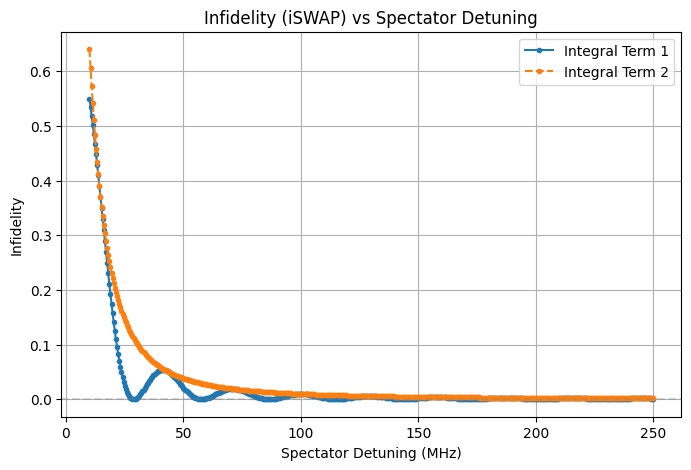

In [6]:
# Parameter sweeps
delta_list = 1e6 * np.linspace(10, 250, 512)  # Fine-grain sweep over delta (MHz)

fidelity_dict1 = {}  # Store fidelity for integral_term1
fidelity_dict2 = {}  # Store fidelity for integral_term2
tf_dict = {}  # Store t_f values for each delta

for delta in tqdm(delta_list):
    g_eff = 6 * np.sqrt(4) * g3 * (lambdaq**2)  # Use n_s = 4 for sqrt(n_s) -> eta
    t_f = full_pulse / g_eff

    # Interaction terms
    interaction_term = q1dag * q2 + q1 * q2dag
    spectator_term = q3dag * q4 + q3 * q4dag
    # specator_term = q1dag + q1

    # Integral terms
    integral_term1 = 2 * np.sin(t_f * delta / 2) / delta
    integral_term2 = 2 / delta

    # Time evolution operators for both terms
    U_t_f1 = (
        1j * g_eff * (t_f * interaction_term + integral_term1 * spectator_term)
    ).expm()

    U_t_f2 = (
        1j * g_eff * (t_f * interaction_term + integral_term2 * spectator_term)
    ).expm()

    # Fidelity calculation
    target_iswap = tensor(intended_gate, qeye([2, 2]))  # Define the target iSWAP gate

    fidelity1 = 1 - average_gate_fidelity(U_t_f1, target_iswap)
    fidelity2 = 1 - average_gate_fidelity(U_t_f2, target_iswap)

    # Store fidelity and t_f values for current delta
    fidelity_dict1[delta] = fidelity1
    fidelity_dict2[delta] = fidelity2
    tf_dict[delta] = t_f

# Create a comparison plot: fidelity vs. detuning for both integral terms
plt.figure(figsize=(8, 5))

# Plot fidelity for integral_term1
deltas_mhz = np.array(delta_list) / 1e6  # Convert detuning to MHz
fidelity_values1 = [fidelity_dict1[delta] for delta in delta_list]
fidelity_values2 = [fidelity_dict2[delta] for delta in delta_list]

plt.plot(
    deltas_mhz,
    fidelity_values1,
    label="Integral Term 1",
    marker=".",
    linestyle="-",
)
plt.plot(
    deltas_mhz,
    fidelity_values2,
    label="Integral Term 2",
    marker=".",
    linestyle="--",
)

# Formatting the plot
plt.axhline(1 - 0.999, color="gray", linestyle="--", alpha=0.3)
plt.xlabel("Spectator Detuning (MHz)")
plt.ylabel("Infidelity")
plt.title("Infidelity (iSWAP) vs Spectator Detuning")
plt.legend(loc="upper right")
plt.grid(True)

# Display the plot
plt.show()

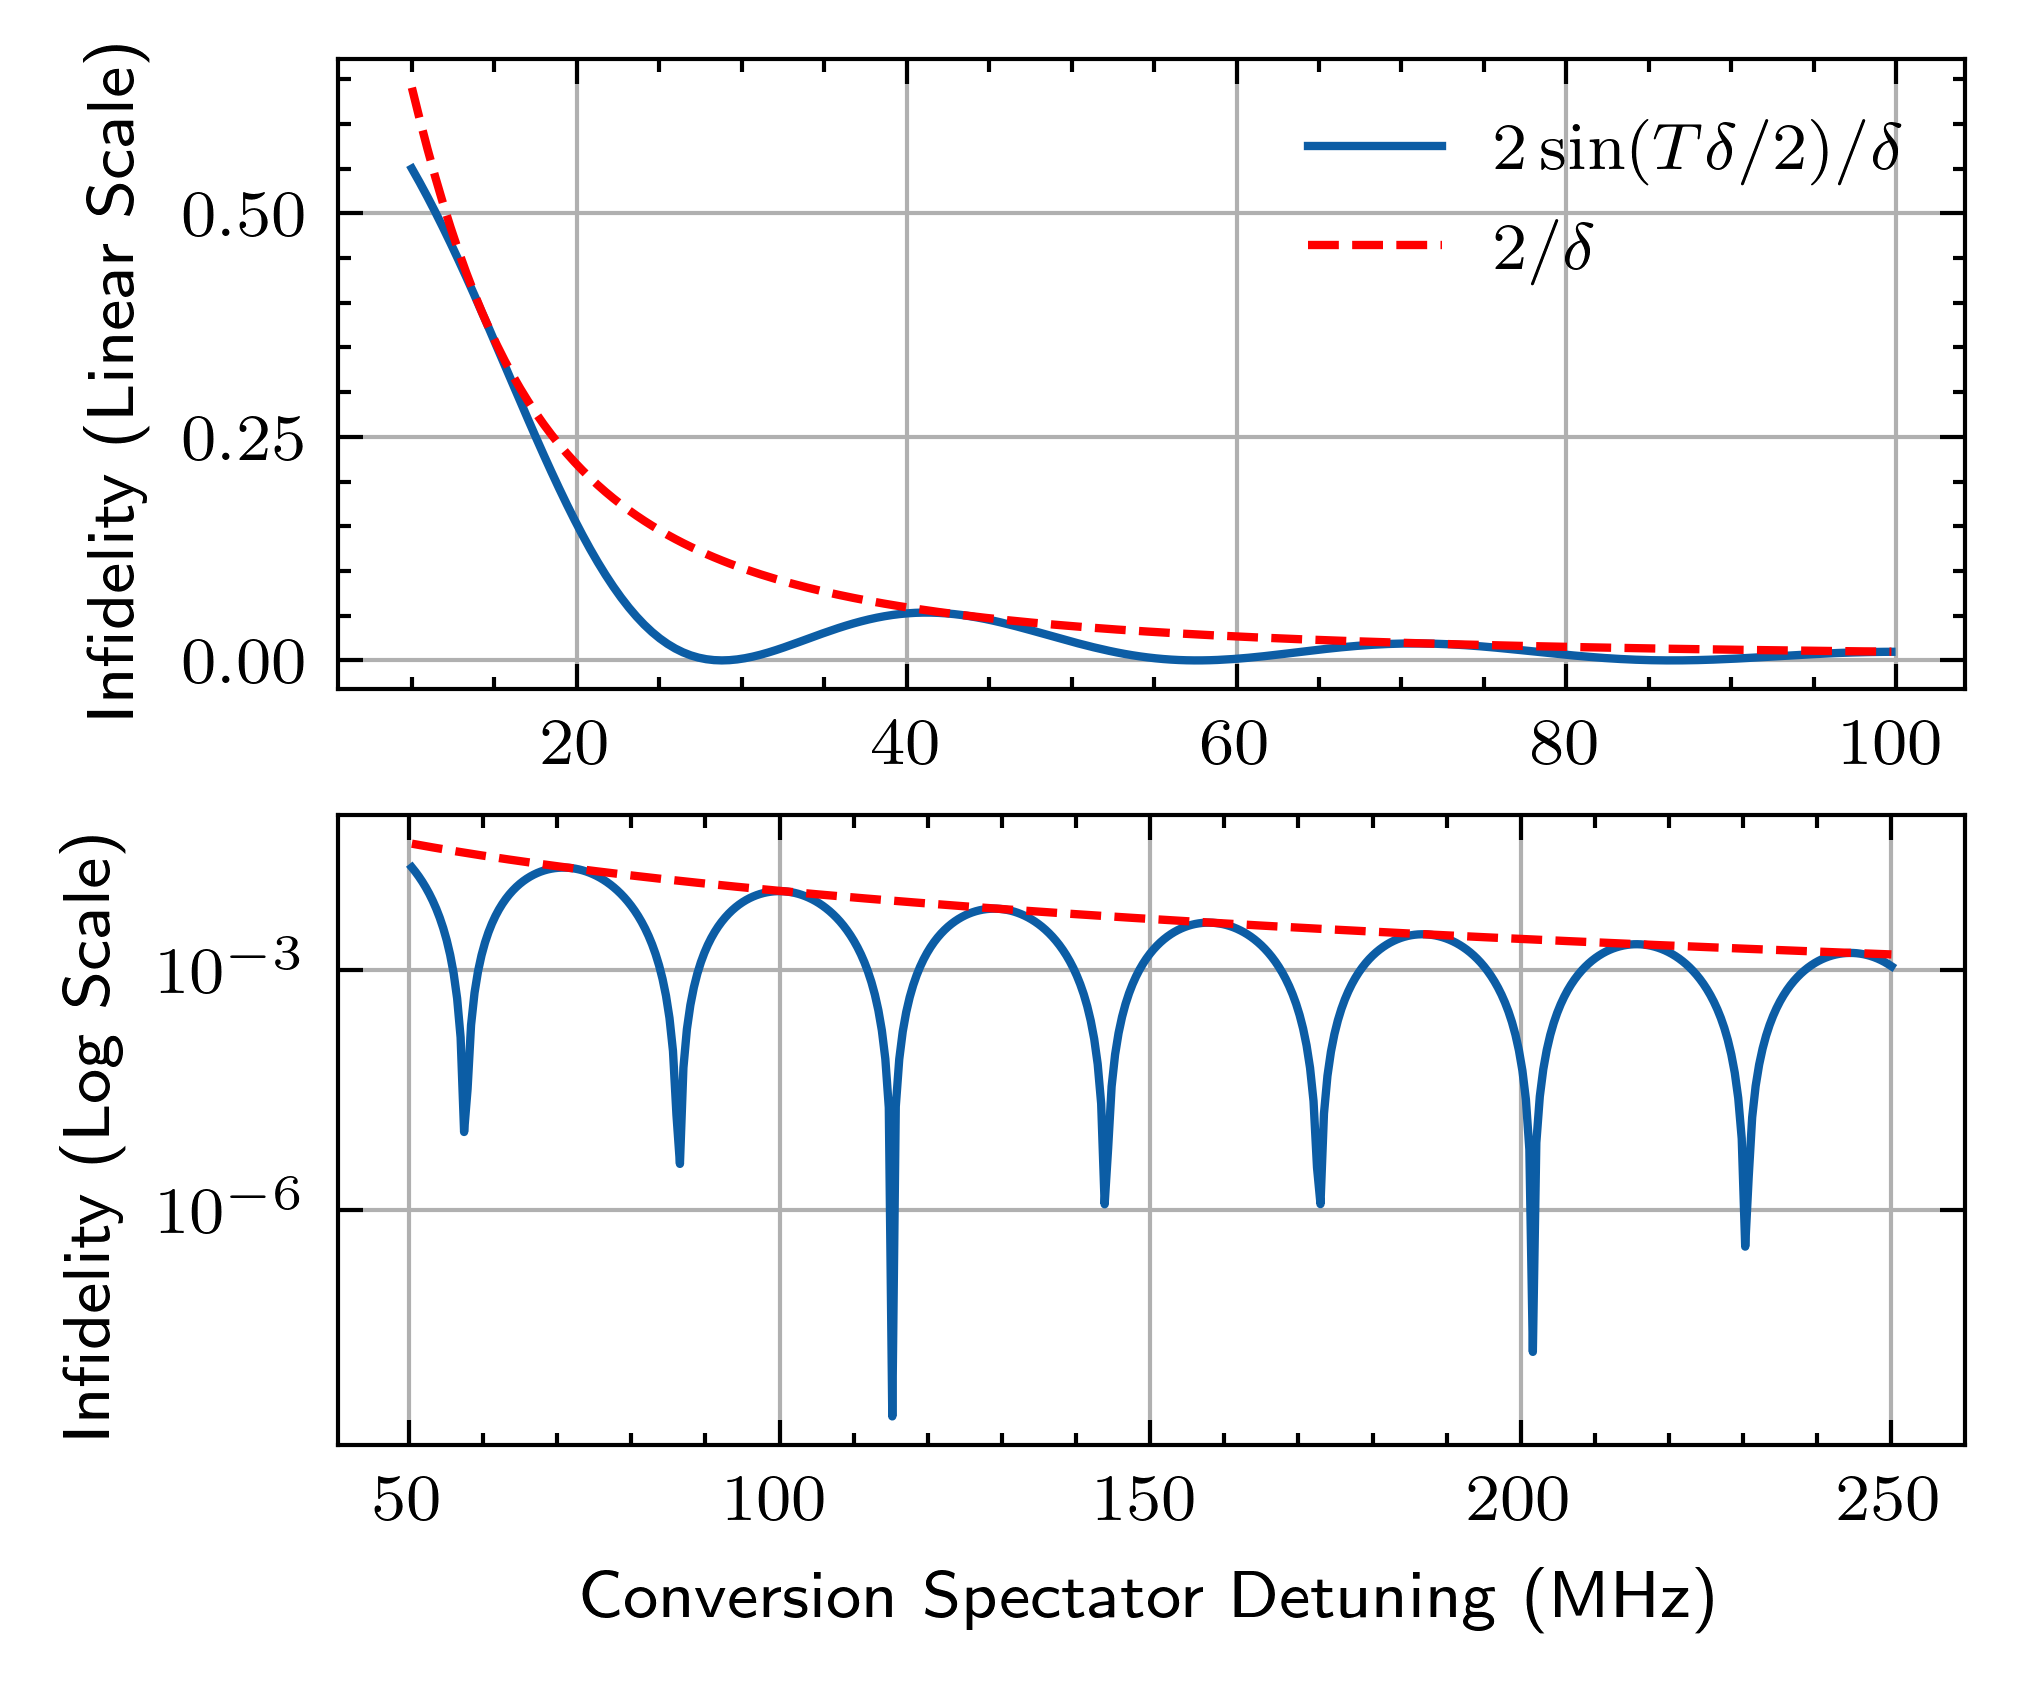

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create the data for the two subplots
deltas_mhz = np.array(delta_list) / 1e6  # Convert detuning to MHz
fidelity_values1 = [fidelity_dict1[delta] for delta in delta_list]
fidelity_values2 = [fidelity_dict2[delta] for delta in delta_list]

# Create subplots
legend_offset = 0.2
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axs = plt.subplots(2, 1, figsize=(3.5, 3))  # , gridspec_kw={'hspace': 0.4})

    # Top subplot: 10 MHz to 100 MHz with linear y-axis
    ax = axs[0]
    mask = (deltas_mhz >= 10) & (deltas_mhz <= 100)
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values1)[mask],
        label="$2 \sin(T \delta / 2) / \delta$",
        linestyle="-",
    )
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values2)[mask],
        label="$2/ \delta$",
        linestyle="--",
        color="red",
    )
    ax.set_ylabel("Infidelity (Linear Scale)")
    ax.legend(fontsize=8)
    ax.grid(True)

    # Bottom subplot: 50 MHz to 250 MHz with log y-axis
    ax = axs[1]
    mask = (deltas_mhz >= 50) & (deltas_mhz <= 250)
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values1)[mask],
        label="$2 \sin(T \delta / 2) / \delta$",
        linestyle="-",
    )
    ax.plot(
        deltas_mhz[mask],
        np.array(fidelity_values2)[mask],
        label="$2/ \delta$",
        linestyle="--",
        color="red",
    )
    ax.set_xlabel("Conversion Spectator Detuning (MHz)")
    ax.set_ylabel("Infidelity (Log Scale)")
    ax.set_yscale("log")
    ax.grid(True)

# Save and display the plot
plt.show()
fig.savefig("fidelity_vs_detuning_subplots.pdf", bbox_inches="tight")

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit


# # Fit fidelity data to the exponential decay function
# spectator_amplitude_list = np.array(spectator_amplitude_list)
# fidelity_list_conversion = np.array(fidelity_list_conversion)
# fidelity_list_subharmonic = np.array(fidelity_list_subharmonic)

# # Fit conversion data
# params_conversion, _ = curve_fit(
#     exponential_decay, spectator_amplitude_list, fidelity_list_conversion, p0=[0, 0]
# )
# # Fit subharmonic data
# params_subharmonic, _ = curve_fit(
#     exponential_decay, spectator_amplitude_list, fidelity_list_subharmonic, p0=[0, 0]
# )

# # Generate fitted curves
# fit_conversion = exponential_decay(spectator_amplitude_list, *params_conversion)
# fit_subharmonic = exponential_decay(spectator_amplitude_list, *params_subharmonic)

# # Plot the data and the fitted curves
# with plt.style.context(["ieee", "use_mathtext", "science"]):
#     plt.figure(figsize=(3.5, 2.5))

#     # Original fidelity curves
#     plt.plot(
#         spectator_amplitude_list,
#         fidelity_list_conversion,
#         label="Spectator (conversion)",
#         linestyle="-",
#     )
#     plt.plot(
#         spectator_amplitude_list,
#         fidelity_list_subharmonic,
#         label="Spectator (subharmonic 1q gate)",
#         linestyle="--",
#     )

#     # Fitted curves
#     plt.plot(
#         spectator_amplitude_list,
#         fit_conversion,
#         label="Fit (conversion, exp. decay)",
#         linestyle=":",
#         color="blue",
#     )
#     plt.plot(
#         spectator_amplitude_list,
#         fit_subharmonic,
#         label="Fit (subharmonic, exp. decay)",
#         linestyle=":",
#         color="green",
#     )

#     # Add labels and legend
#     plt.xlabel("Spectator amplitude")
#     plt.ylabel("Infidelity")
#     plt.title("Infidelity (iSWAP) vs Spectator amplitude")
#     plt.legend(fontsize=8)
#     plt.grid(True)

# # Show the plot
# plt.show()

# # Print fitted parameters
# print("Fitted Parameters (Conversion):")
# print(f"a = {params_conversion[0]:.3f}, b = {params_conversion[1]:.3f}")

# print("Fitted Parameters (Subharmonic):")
# print(f"a = {params_subharmonic[0]:.3f}, b = {params_subharmonic[1]:.3f}")